# Selection of predictors and Model selection

In [1]:
import pandas as pd 
import numpy as np
from plotnine import *
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import statistics
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.combine import SMOTEENN 



In [2]:
#### params 
dates= [  'DateCalc', 'REP_DATE', 'FIRST_PROD_DATE',  'DATE_PENS_DOC', 'DATE_FIRST_KDV_WITHOUT_CEL', 'DATE_FIRST_KDV_CEL', 'P24_DATREG', 'P24_LEDATE', 'DATE_LAST_PHOTO', 
        'MIN_DATEFIRST_DB_CRCARDS', 'MIN_DATESTART_ALL_CRCARDS'] 
y_column= 'Target_30_90d'

In [3]:
train = pd.read_parquet('train.parquet')
#test = pd.read_parquet('test.parquet')
validation = pd.read_parquet('validation.parquet')

del train['TYPE_BASE']
#del test['TYPE_BASE']
del validation['TYPE_BASE']
del train['REP_DATE_month']
#del test['REP_DATE_month']
del validation['REP_DATE_month']


In [4]:
print(train['Target_30_90d'].value_counts(dropna=False)/ train.shape[0])
print(validation['Target_30_90d'].value_counts(dropna=False)/ validation.shape[0])

0.0    0.889343
1.0    0.110657
Name: Target_30_90d, dtype: float64
0.0    0.877573
1.0    0.122427
Name: Target_30_90d, dtype: float64


## Remove predictors that are poorly filled

The first approach to removing features with a high number of nulls was an 80-20 strategy, i.e. retain the features that originate 20% of total nulls. However, this strategy was not used since, as we can see, to achieve the above, 87 features are required, which, considering the sample number, is a high number of features.

In [5]:
temp = pd.DataFrame(train.isna().sum())
temp.columns= ['Freq']
temp = temp.reset_index()
index = temp.Freq ==0
features = list(temp.loc[index, 'index'] )
temp = temp[~index].copy()
import gc 
gc.collect()
temp['P_nulls_total']=temp.Freq / temp.Freq.sum()
temp = temp.sort_values(by='P_nulls_total')
temp['P_nulls_cumsum'] = temp.P_nulls_total.cumsum()
temp = temp.reset_index()
temp = temp.drop('level_0', axis=1)
temp.columns = ['Feature', 'Freq', 'P_nulls_total', 'P_nulls_cumsum']
temp 

,Feature,Freq,P_nulls_total,P_nulls_cumsum
0,FL_4P,5,0.000002,0.000002
1,CL_PHOTO_4,5,0.000002,0.000004
2,CL_PHOTO_3,5,0.000002,0.000006
3,CL_PHOTO_2,5,0.000002,0.000008
4,CL_PHOTO_1,5,0.000002,0.000010
...,...,...,...,...
428,REP_RLCL_LIMIT_12,35746,0.013722,0.945099
429,REP_RLCL_MAXPAY,35753,0.013724,0.958823
430,QTY_AFTER_CALL_OC_NF_O2_1M,35755,0.013725,0.972548
431,DATE_PENS_DOC,35756,0.013725,0.986274


In [6]:
(temp.shape[0]/100)*20

86.6

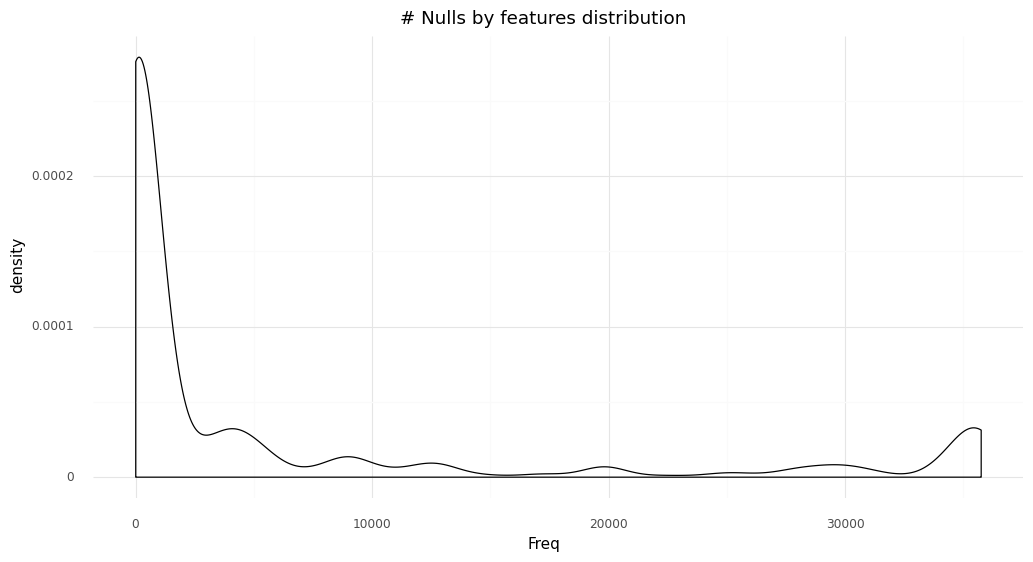

<ggplot: (276680512)>

In [7]:
ggplot(temp, aes(x='Freq')) + geom_density() + theme_minimal() +theme (figure_size=(12, 6) )  + ggtitle('# Nulls by features distribution') 

The first step in ruling out features that have a large number of nulls was to test for independence between the response variable and the presence of nulls. 

The purpose of the above is to know if the lack of response follows a pattern related to the variable to be predicted, given that the data acquisition mechanism is unknown a priori.

To do this, a $\chi^2$ test was performed on each characteristic and those in which the independence hypothesis was not rejected were discarded.

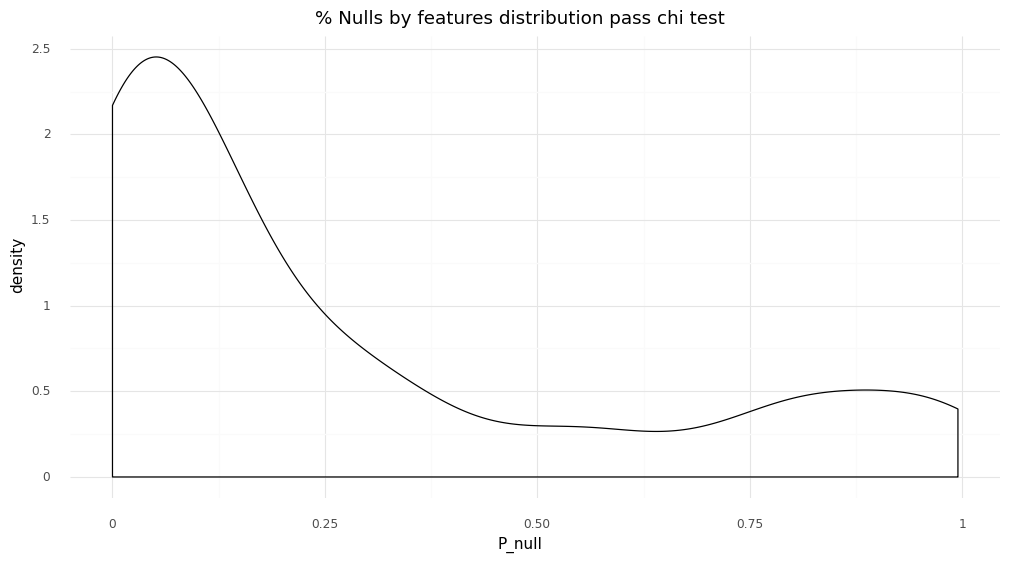

<ggplot: (361176977)>

In [8]:
temp['P_value_chi2'] = -1
train.Target_30_90d = train.Target_30_90d.astype(str)
for c in temp.index: 
    columna = temp.loc[c, 'Feature']
    temp2 = pd.DataFrame(columns=['Feature', 'Target_30_90d'])
    temp2['Target_30_90d'] = train.Target_30_90d
    index = train[columna].isna()
    temp2.loc[index, 'Feature'] = 'NULL'
    temp2.loc[~index, 'Feature'] = 'No null'#train[columna][~index]
    crosstab = pd.crosstab(temp2["Target_30_90d"], temp2["Feature"])
    temp.loc[ c ,'P_value_chi2'] =   stats.chi2_contingency(crosstab)[1] # p-value the hypothesis test of independence 

index = temp.P_value_chi2 >= 0.05 # significan features
temp = temp[~index].copy()

features = features + list(temp.Feature)
train = train.loc[:, features]
temp = pd.DataFrame(train.isna().sum())
temp.columns= ['Freq']
temp['P_null']= temp.Freq / train.shape[0]
ggplot(temp, aes(x='P_null')) + geom_density() + theme_minimal() +theme (figure_size=(12, 6) )  + ggtitle('% Nulls by features distribution pass chi test') 

##  Convert dates to numeric

In [9]:
dates = [ _ for _ in dates if _ in features]  
for _ in dates: 
    train[_] = pd.to_datetime( train[_])  
    validation[_] = pd.to_datetime(validation[_])
    #test[_] = pd.to_datetime(test[_])

for _ in dates: 
    if _ != 'DateCalc':
        train[_] =  train['DateCalc'] - train[_] 
        train[_] = train[_].dt.days
        #test[_] =  test['DateCalc'] - test[_]
        #test[_] = test[_].dt.days
        validation[_] =  validation['DateCalc'] - validation[_] 
        validation[_] =  validation[_].dt.days
        
train[dates].head()

,DateCalc,REP_DATE,DATE_FIRST_KDV_WITHOUT_CEL,DATE_FIRST_KDV_CEL,P24_DATREG,P24_LEDATE,MIN_DATEFIRST_DB_CRCARDS
0,2019-03-01,-16,2703.0,2786.0,2465.0,20.0,2754.0
1,2019-05-01,-30,2764.0,2847.0,2773.0,7.0,2815.0
2,2019-03-01,-12,NaN,NaN,786.0,65.0,756.0
3,2019-07-01,-27,NaN,NaN,650.0,171.0,1121.0
4,2019-04-01,-23,NaN,NaN,144.0,NaN,989.0


## Encoding features

For the nominal variables that passed the $\chi^2$ test, we do not remove the nulls but replace them with another string, since the test indicates that the non-response is not independent respect the target variable.

In [10]:
%%time
pt = StandardScaler()

train[dates[ 1:] ]  = pt.fit_transform(train[dates[ 1:]] )
validation[dates[ 1:] ]  = pt.transform(validation[dates[ 1:]] )
#test[dates[ 1:] ]  = pt.transform(test[dates[ 1:]] )

for c in dates[ 1:]: 
    index = train[c].isna()
    train.loc[index, c] = statistics.mode( train[c])
    #index = test[c].isna()
    #test.loc[index, c] = statistics.mode( train[c])
    index = validation[c].isna()
    validation.loc[index, c] = statistics.mode( train[c])

index = train.dtypes == object

non_numeric_cols = list(train.dtypes.index[index])
numeric_cols = list( train.dtypes.index[~index] )
numeric_cols = [ _ for _ in numeric_cols if _ not in dates]


pt_numerics=StandardScaler()
train[numeric_cols[1:]] =  pt_numerics.fit_transform(train[numeric_cols[1:]])
#test[numeric_cols[1:]] =  pt_numerics.transform(test[numeric_cols[1:]])
validation[numeric_cols[1:]] =  pt_numerics.transform(validation[numeric_cols[1:]])

      
for c in numeric_cols[ 1:]: 
    index = train[c].isna()
    train.loc[index, c] = statistics.mode( train[c])
    #index = test[c].isna()
    #test.loc[index, c] = statistics.mode( train[c])
    index = validation[c].isna()
    validation.loc[index, c] = statistics.mode( train[c])
    
for c in non_numeric_cols[1:]: 
    index = train[c].isna()
    train.loc[ index, c ] ='NULL' 
    #index = test[c].isna()
    #test.loc[ index, c ] ='NULL' 
    index = validation[c].isna()
    validation.loc[ index, c ] ='NULL' 

pt_ordinal =  OrdinalEncoder()
pt_ordinal.fit(pd.concat([train[non_numeric_cols[1:]], validation[non_numeric_cols[1:]] ] ) )

train[non_numeric_cols[1:]] = pt_ordinal.transform(train[non_numeric_cols[1:]])
#test[non_numeric_cols[1:]] = pt_ordinal.transform(test[non_numeric_cols[1:]])
validation[non_numeric_cols[1:]] = pt_ordinal.transform(validation[non_numeric_cols[1:]])

CPU times: user 5min 49s, sys: 1.51 s, total: 5min 51s
Wall time: 5min 51s


In [11]:
y_train = train[y_column].copy()
y_validation = validation[y_column].copy()
y_validation = y_validation.astype(str)
y_test = validation[y_column].copy()


del train[y_column]
del validation[y_column]
#del test[y_column]

features = dates + non_numeric_cols[1:] + numeric_cols[1:]


Next, we evaluate the individual importance of each feature to discard those that provide less information.

As a result, the model will be trained with the 30 features with the highest score that are significant (p_value > 0.5)


/Users/antonio/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 50  53  73  74  75  76 155] are constant.
/Users/antonio/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
/Users/antonio/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 7 rows containing non-finite values.


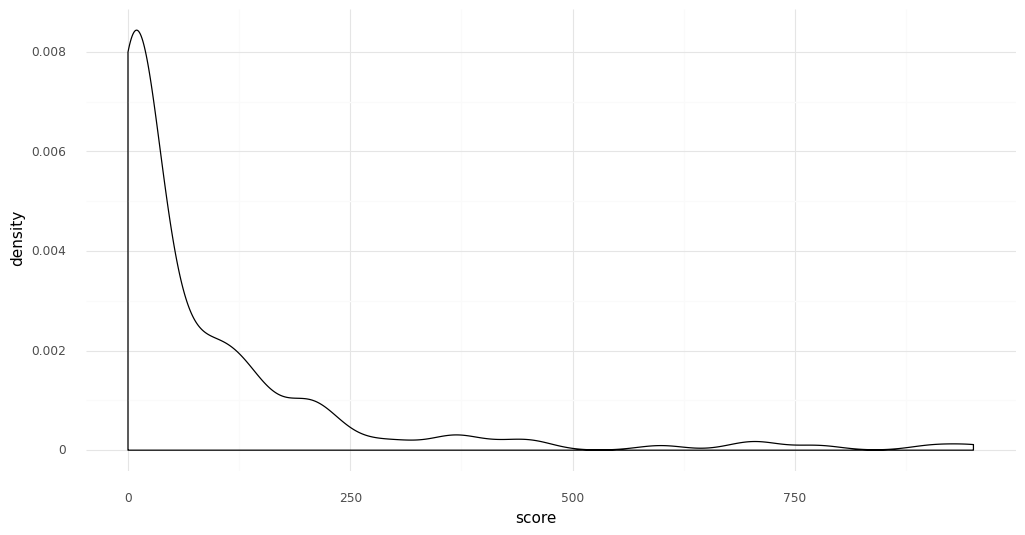

<ggplot: (358596855)>

In [12]:

selector = SelectKBest(f_classif, k='all')
selector.fit(train.loc[:, features[1:]], y_train)
temp = pd.DataFrame(columns=['Feature', 'p_value', 'score'] ) 
temp.Feature = features[1:]
temp.p_value = selector.pvalues_
temp.score = selector.scores_
temp = temp.sort_values(by='p_value')
ggplot(temp, aes(x='score')) + geom_density() + theme_minimal() +theme (figure_size=(12, 6) ) 

# Model selection

Since we are working with an unbalanced sample, we apply a resampling technique on the class with the least frequency in the sample (value 1).

For model selection, we only try with easily interpretable models due to the nature of the model and the use case we are dealing with.

After observing which model has the best performance, a hyperparameter search is performed to improve the results.

172


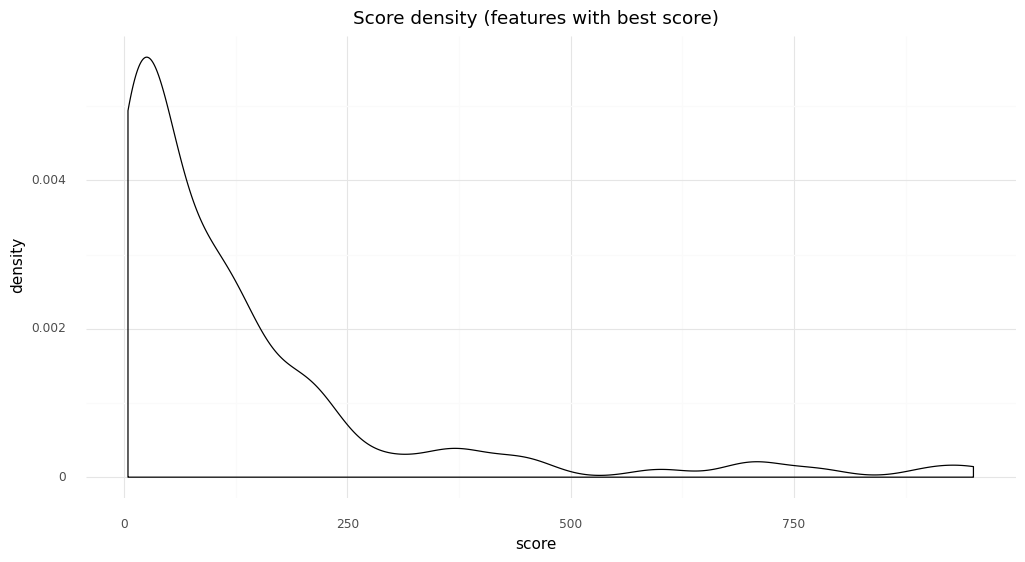

<ggplot: (361152085)>

In [13]:
k= 30 
temp2 = temp[temp.p_value<0.05].copy()
print(len(selector.scores_))
temp2 = temp2.sort_values(by='score', ascending=False)
features = temp2.Feature[0:k]

ggplot(temp2, aes(x='score')) + geom_density() + theme_minimal() +theme (figure_size=(12, 6) ) + ggtitle("Score density (features with best score)") 

In [14]:
X_train = train[features]
X_val = validation[features]
sme = SMOTEENN(random_state=0)
X_train_r, y_train_r = sme.fit_resample(X_train, y_train)
print(y_train_r.value_counts())


1.0    31155
0.0    18080
Name: Target_30_90d, dtype: int64


              precision    recall  f1-score   support

         0.0       0.64      0.52      0.57     18080
         1.0       0.75      0.83      0.79     31155

    accuracy                           0.71     49235
   macro avg       0.69      0.67      0.68     49235
weighted avg       0.71      0.71      0.71     49235



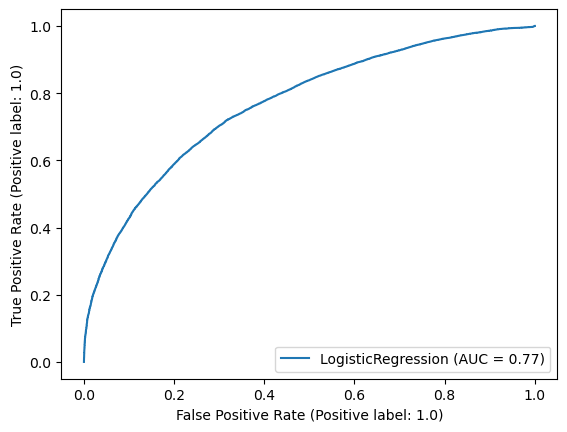

              precision    recall  f1-score   support

         0.0       0.93      0.44      0.59      8057
         1.0       0.16      0.77      0.27      1124

    accuracy                           0.48      9181
   macro avg       0.55      0.60      0.43      9181
weighted avg       0.84      0.48      0.55      9181



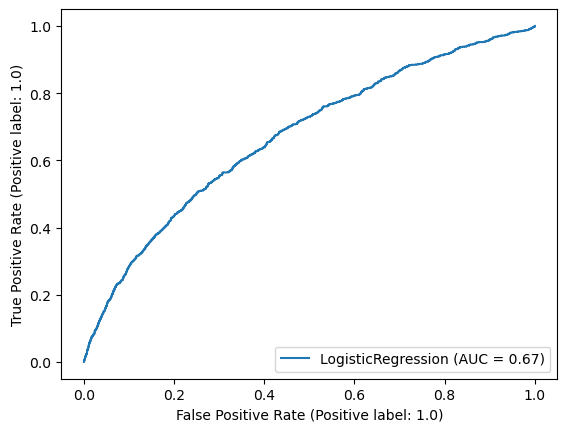

              precision    recall  f1-score   support

         0.0       0.74      0.66      0.70     18080
         1.0       0.82      0.86      0.84     31155

    accuracy                           0.79     49235
   macro avg       0.78      0.76      0.77     49235
weighted avg       0.79      0.79      0.79     49235



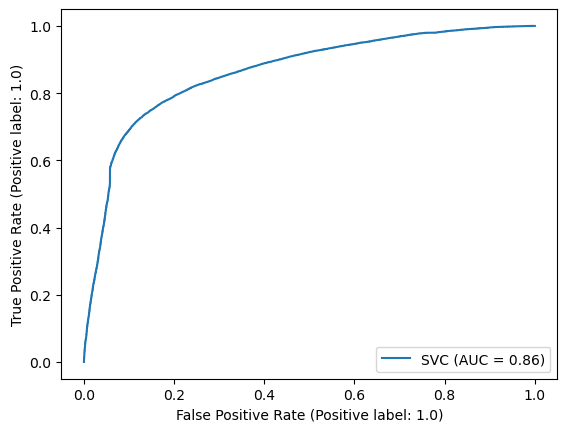

              precision    recall  f1-score   support

         0.0       0.93      0.52      0.66      8057
         1.0       0.17      0.70      0.27      1124

    accuracy                           0.54      9181
   macro avg       0.55      0.61      0.47      9181
weighted avg       0.83      0.54      0.62      9181



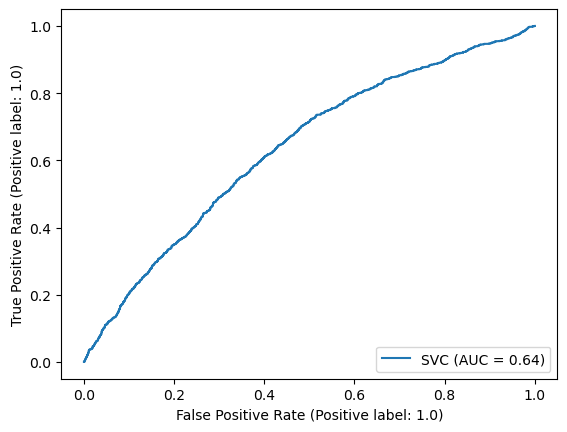

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18080
         1.0       1.00      1.00      1.00     31155

    accuracy                           1.00     49235
   macro avg       1.00      1.00      1.00     49235
weighted avg       1.00      1.00      1.00     49235



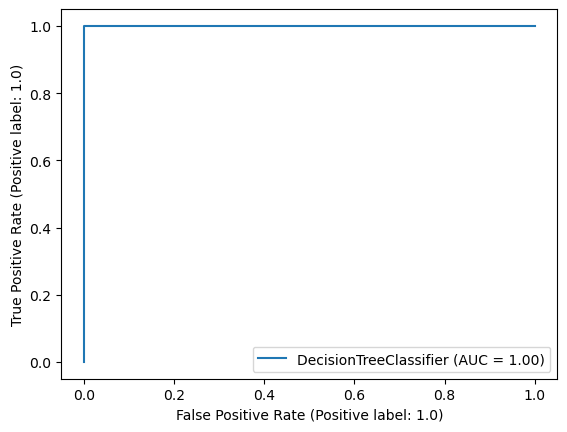

              precision    recall  f1-score   support

         0.0       0.90      0.78      0.83      8057
         1.0       0.18      0.36      0.24      1124

    accuracy                           0.73      9181
   macro avg       0.54      0.57      0.54      9181
weighted avg       0.81      0.73      0.76      9181



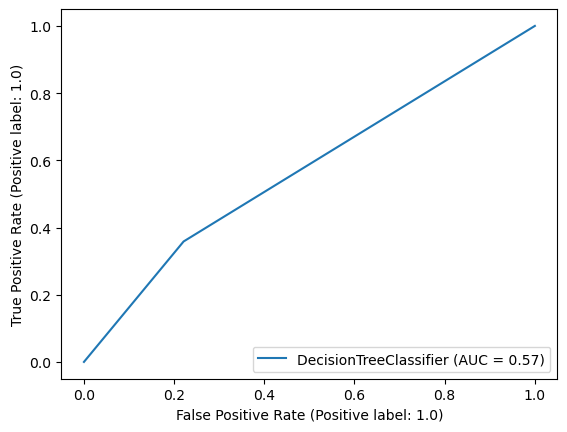

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18080
         1.0       1.00      1.00      1.00     31155

    accuracy                           1.00     49235
   macro avg       1.00      1.00      1.00     49235
weighted avg       1.00      1.00      1.00     49235



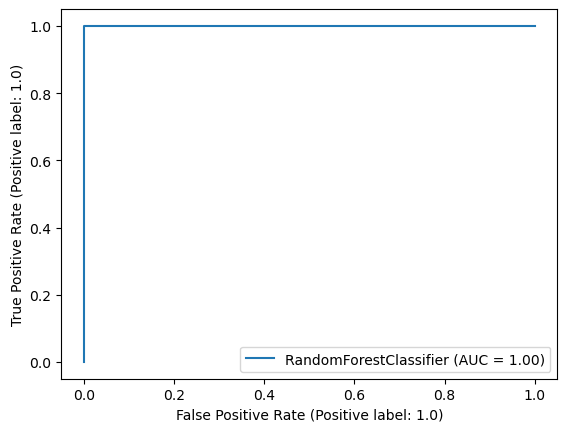

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      8057
         1.0       0.27      0.31      0.29      1124

    accuracy                           0.81      9181
   macro avg       0.58      0.60      0.59      9181
weighted avg       0.82      0.81      0.82      9181



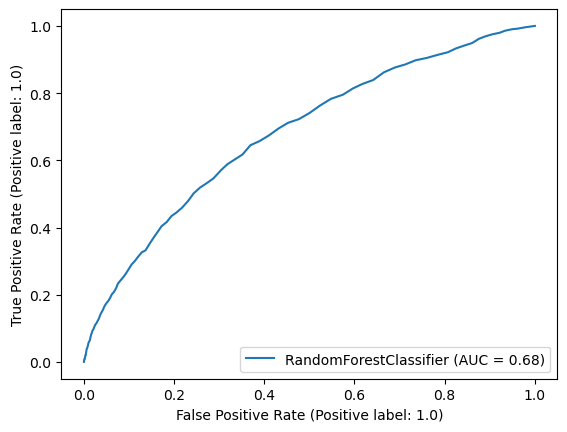

/Users/antonio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85     18080
         1.0       0.90      0.92      0.91     31155

    accuracy                           0.89     49235
   macro avg       0.88      0.88      0.88     49235
weighted avg       0.89      0.89      0.89     49235



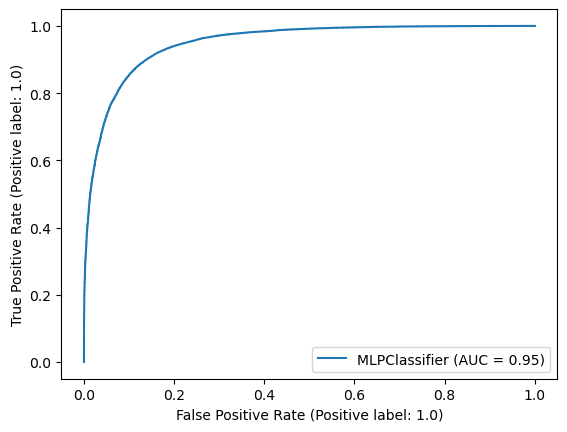

              precision    recall  f1-score   support

         0.0       0.91      0.66      0.76      8057
         1.0       0.17      0.51      0.26      1124

    accuracy                           0.64      9181
   macro avg       0.54      0.58      0.51      9181
weighted avg       0.82      0.64      0.70      9181



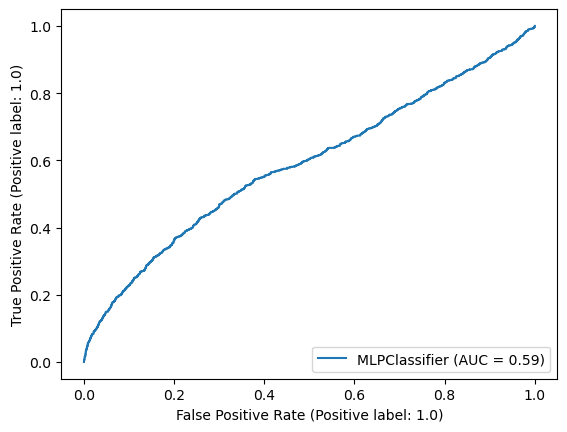

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     18080
         1.0       0.89      0.90      0.89     31155

    accuracy                           0.86     49235
   macro avg       0.85      0.85      0.85     49235
weighted avg       0.86      0.86      0.86     49235



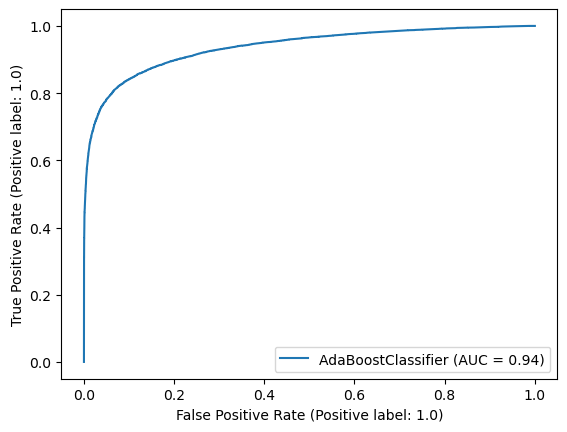

              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83      8057
         1.0       0.23      0.50      0.31      1124

    accuracy                           0.73      9181
   macro avg       0.57      0.63      0.57      9181
weighted avg       0.83      0.73      0.77      9181



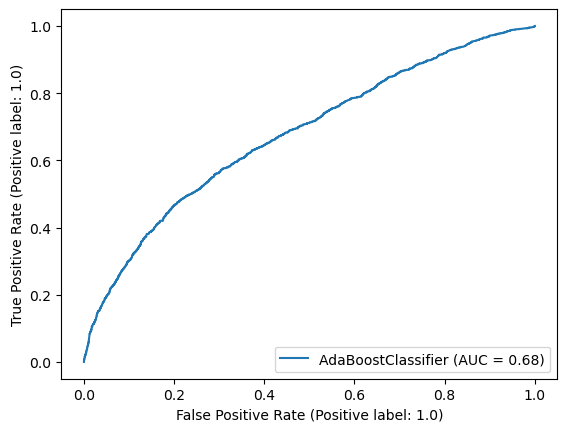

              precision    recall  f1-score   support

         0.0       0.47      0.84      0.60     18080
         1.0       0.83      0.44      0.57     31155

    accuracy                           0.59     49235
   macro avg       0.65      0.64      0.59     49235
weighted avg       0.70      0.59      0.58     49235



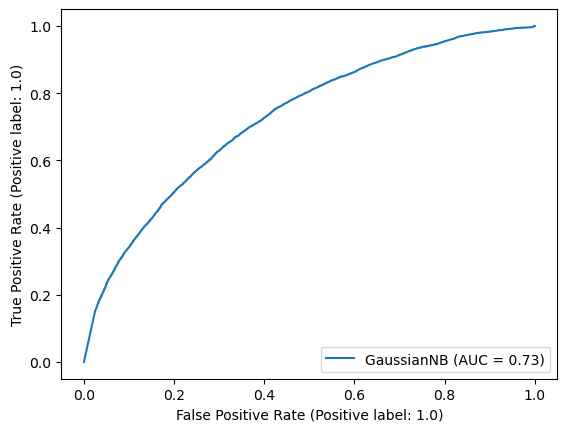

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      8057
         1.0       0.22      0.49      0.30      1124

    accuracy                           0.72      9181
   macro avg       0.57      0.62      0.56      9181
weighted avg       0.83      0.72      0.76      9181



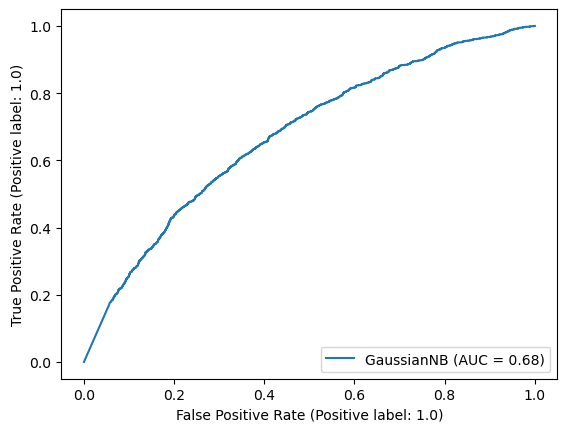

              precision    recall  f1-score   support

         0.0       0.45      0.85      0.59     18080
         1.0       0.82      0.40      0.54     31155

    accuracy                           0.56     49235
   macro avg       0.64      0.62      0.56     49235
weighted avg       0.69      0.56      0.56     49235



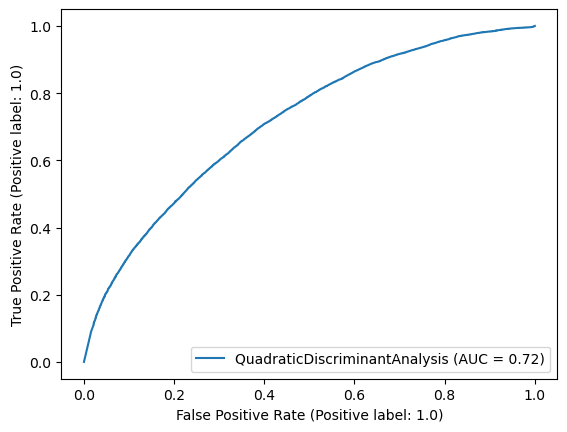

              precision    recall  f1-score   support

         0.0       0.92      0.60      0.72      8057
         1.0       0.18      0.62      0.28      1124

    accuracy                           0.60      9181
   macro avg       0.55      0.61      0.50      9181
weighted avg       0.83      0.60      0.67      9181



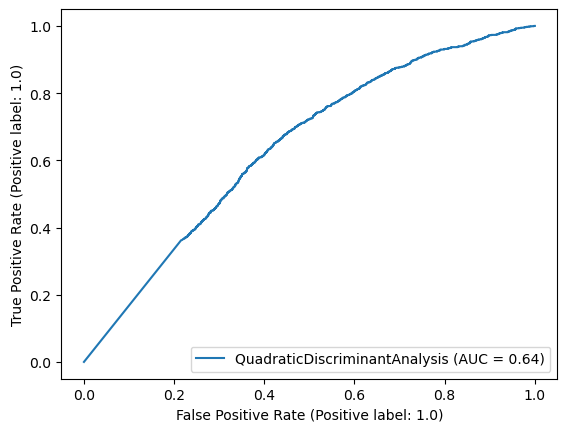

CPU times: user 8min 26s, sys: 24.3 s, total: 8min 50s
Wall time: 4min 30s


In [15]:
%%time
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import gc 


classifiers = [
    LogisticRegression(), 
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


for clf in classifiers: 
    # train
    clf.fit(X_train_r, y_train_r)
    y_train_out = clf.predict(X_train_r)
    print(classification_report(y_train_r, y_train_out))
    print(RocCurveDisplay.from_estimator(clf, X_train_r, y_train_r))
    plt.show()
        
    # testing 
    y_val_out = clf.predict(X_val)
    print(classification_report(y_validation, y_val_out))
    RocCurveDisplay.from_estimator(clf, X_val, y_validation)
    plt.show()
    gc.collect()
        

After observing the previous results, __Adaboost__ is chosen as the classifier because the area under the ROC curve is greater in the _test_ set, in addition to having greater precision, recall and __F1-score__ than the other models.

In [16]:
%%time
#grid search 
from sklearn.model_selection import RandomizedSearchCV
ada = AdaBoostClassifier( random_state=0)
distributions_ada = dict(n_estimators=stats.randint(10, 100), learning_rate=stats.uniform(0.1, 2), algorithm=['SAMME', 'SAMME.R']) 
clf_ada = RandomizedSearchCV(ada, distributions_ada, random_state=0, n_iter=100, n_jobs=8, cv=10)
search_ada = clf_ada.fit(X_train, y_train)
gc.collect()
params = search_ada.best_params_
params

CPU times: user 11.2 s, sys: 1.47 s, total: 12.7 s
Wall time: 13min 55s


{'algorithm': 'SAMME.R',
 'learning_rate': 0.3374554379084881,
 'n_estimators': 72}

              precision    recall  f1-score   support

         0.0       0.80      0.69      0.74     18080
         1.0       0.83      0.90      0.87     31155

    accuracy                           0.82     49235
   macro avg       0.82      0.79      0.80     49235
weighted avg       0.82      0.82      0.82     49235



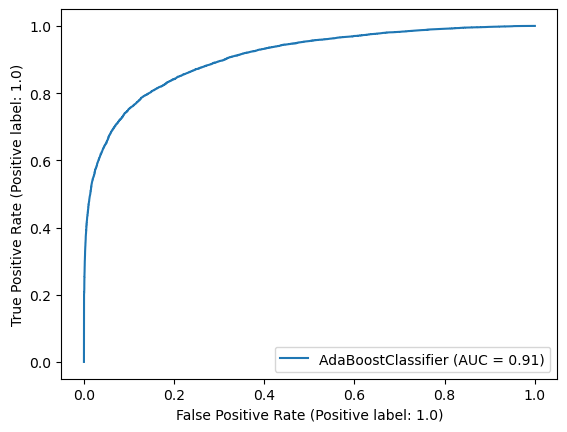

              precision    recall  f1-score   support

         0.0       0.93      0.62      0.74      8057
         1.0       0.19      0.64      0.29      1124

    accuracy                           0.62      9181
   macro avg       0.56      0.63      0.52      9181
weighted avg       0.84      0.62      0.69      9181



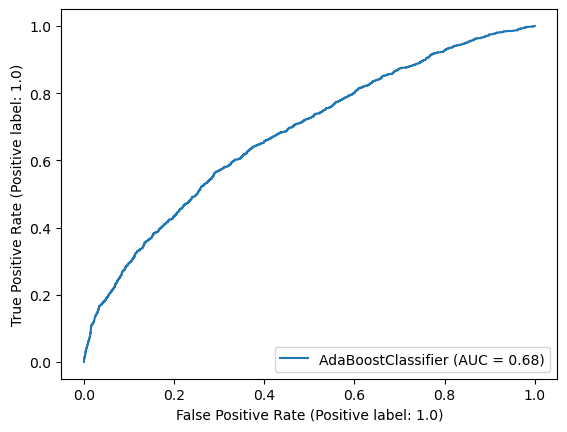

In [17]:
clf_ada = AdaBoostClassifier( random_state=0, n_estimators=params['n_estimators']  , learning_rate=params['learning_rate'], algorithm=params['algorithm'])
clf_ada.fit(X_train_r, y_train_r)
y_train_out = clf_ada.predict(X_train_r)
print(classification_report(y_train_r, y_train_out))
print(RocCurveDisplay.from_estimator(clf_ada, X_train_r, y_train_r))
plt.show()
y_val_out = clf_ada.predict(X_val)
print(classification_report(y_validation, y_val_out))
RocCurveDisplay.from_estimator(clf_ada, X_val, y_validation)
plt.show()

In [18]:
y_scoring = clf_ada.predict_proba(X_train_r)
#y_scoring = clf_ada.predict_proba(X_val)
y_scoring = pd.DataFrame(y_scoring)
y_scoring.columns = ['Prob_0', 'Prob_1']
deciles = np.quantile(y_scoring['Prob_1'],q =[ _/100 for _ in range(10, 110, 10)] )
table3 = pd.DataFrame( columns=['Decile', 'LowerScoreBound', 'Qty', 'NumberGood', 'NumberBad',  'PercentageGood' ] ) 
table3['Decile'] = [ _ for _ in range(1, 11) ]
table3.LowerScoreBound = deciles 
#y_scoring['y'] = y_val_out
y_scoring['y'] = y_train_r
y_scoring['Decile']=-1
for _ in range(0,10):
    if _==0:
        limit_inf = table3.loc[_, 'LowerScoreBound']
        index = y_scoring.Prob_1 <= limit_inf
        y_scoring.loc[ index, 'Decile']= 1
    else : 
        limit_inf = table3.loc[_-1, 'LowerScoreBound']
        limit_sup = table3.loc[_, 'Decile']
        index = (y_scoring.Prob_1 > limit_inf) & ( y_scoring.Prob_1 <= limit_sup) 
        y_scoring.loc[index, 'Decile']= _ +1

t = pd.DataFrame(y_scoring['Decile'].value_counts())
t = t.reset_index()
t =t.sort_values(by= 'index')

table3.Qty = t.Decile
t = y_scoring.groupby(['Decile', 'y'])['Prob_1'].agg('count')
t = t.reset_index()
t.columns = ['Decile','y', 'count']


for _ in t.index: 
    decile = t.loc[_, 'Decile']
    index = table3.Decile == decile
    y_t = t.loc[_, 'y']
    if y_t == '0.0': 
        table3.loc[index, 'NumberBad'] = t.loc[_, 'count']
    if y_t == '1.0':
        table3.loc[index, 'NumberGood'] = t.loc[_, 'count']
index = table3.NumberBad.isna()
table3.loc[index, 'NumberBad'] = 0 
index = table3.NumberGood.isna()
table3.loc[index, 'NumberGood'] = 0 
table3.PercentageGood = table3.NumberGood/ table3.Qty 


The breakdown of clients by deciles is shown in the following table

In [19]:
table3

,Decile,LowerScoreBound,Qty,NumberGood,NumberBad,PercentageGood
0,1,0.485933,4925,388,4536,0.078782
1,2,0.493253,4924,888,4035,0.180341
2,3,0.499137,4924,1489,3436,0.302396
3,4,0.504434,4924,2326,2597,0.47238
4,5,0.509597,4924,3067,1857,0.622868
5,6,0.514783,4923,3947,976,0.801747
6,7,0.520464,4923,4465,457,0.906967
7,8,0.526393,4923,4779,145,0.97075
8,9,0.534480,4923,4885,39,0.992281
9,10,0.565922,4922,4921,2,0.999797


In [20]:
import shap
n = int(round(X_train.shape[0]/10, 0))
print(n) 
Xn = shap.utils.sample(X_train_r, n)
explainer = shap.Explainer(clf_ada.predict, Xn)
shap_values = explainer(X_train_r)

3576



Compilation is falling back to object mode WITH looplifting enabled because Function "_build_fixed_single_output" failed type inference due to: non-precise type array(pyobject, 1d, C)
During: typing of argument at /Users/antonio/anaconda3/lib/python3.9/site-packages/shap/utils/_masked_model.py (349)

File "../../../../anaconda3/lib/python3.9/site-packages/shap/utils/_masked_model.py", line 349:
def _build_fixed_single_output(averaged_outs, last_outs, outputs, batch_positions, varying_rows, num_varying_rows, link):
    <source elided>
    # to carry over evaluation outputs
    last_outs[:] = outputs[batch_positions[0]:batch_positions[1]]
    ^


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_build_fixed_single_output" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../anaconda3/lib/python3.9/site-packages/shap/utils/_masked_model.py", line 353:
def _build_fixed_single_outp

The meaning and importance of the predictors used in the model is shown in the following figure.

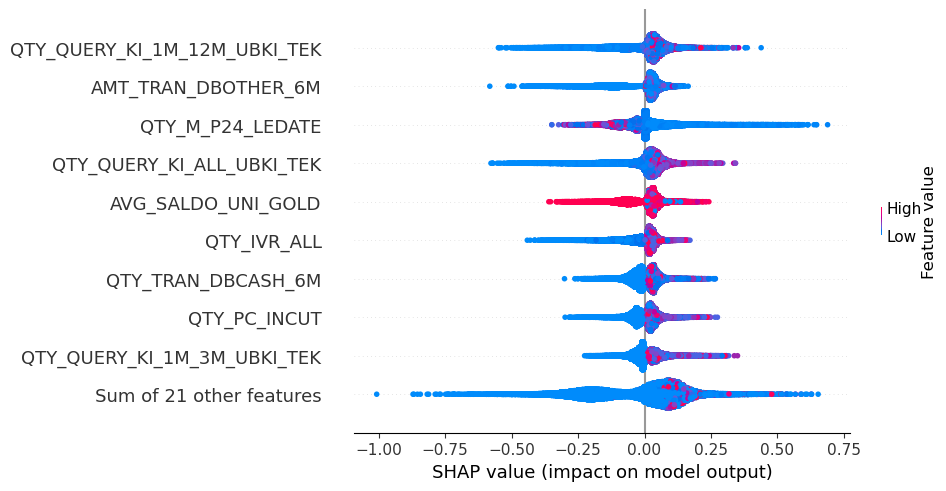

In [21]:
shap.plots.beeswarm(shap_values)

Finally the model is saved

In [22]:
import joblib
joblib.dump(clf_ada, 'classifier' + '.gz', compress='gzip')

['classifier.gz']